In [2]:
# %%
import os
import random
import numpy as np
import pandas as pd

import torch
import clip

from data import *
from model import *


In [2]:

# %%
BATCH_SIZE = 1
RANDOM_SEED = 42

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

reps_df = pd.read_csv("reps.csv")
reps_df['img'] = reps_df.apply(lambda row: preprocess(Image.open(row['img_path'])), axis=1)

reps_data = headcam_data(reps_df)
reps_loader = torch.utils.data.DataLoader(reps_data, batch_size=BATCH_SIZE, shuffle=False)


In [3]:

# %%
models = [f[:-3] for f in os.listdir("models") if f.endswith(".pt")]
model_configs = [m.split("_") for m in models]
model_configs = [{f:v for f,v in zip(config[::2], config[1::2])} for config in model_configs]
model_configs = pd.DataFrame(model_configs, dtype="float")
model_configs['path'] = models


In [4]:
mlp = torch.load(f'models/img_0.2_txt_0.4_hid_128_lr_0.0001.pt')

In [8]:
rep_tensors = []
def get_activation():
    def hook(model, input, output):
        rep_tensors.append(output.detach().numpy())
    return hook

h = mlp.layer3.register_forward_hook(get_activation())

for rep in reps_loader:
    input, labels = rep
    out = mlp(input)

h.remove()

In [59]:
rep_corrs = pd.DataFrame(columns=["img_label_int", "txt_label_int", "corr"])

rep_arr = []
for img in range(6):
    row = []
    for txt in range(6):
        corr = np.corrcoef(rep_tensors[img], rep_tensors[txt+6])[0,1]
        new_corr = pd.DataFrame({"img_label_int": [img], "txt_label_int": [txt], "corr": [corr]})
        rep_corrs = pd.concat((rep_corrs, new_corr))

        row.append(corr)
    rep_arr.append(row)
rep_arr = np.array(rep_arr)
rep_arr

array([[0.89052858, 0.47520513, 0.3852891 , 0.52165176, 0.62155787,
        0.69907597],
       [0.53997862, 0.80225901, 0.56629923, 0.77359204, 0.75975074,
        0.89547906],
       [0.68038616, 0.59428823, 0.76777147, 0.67843843, 0.605655  ,
        0.78693348],
       [0.53589773, 0.78252292, 0.67689008, 0.76225277, 0.8155493 ,
        0.82999037],
       [0.68660736, 0.71747781, 0.68983816, 0.63230815, 0.6935568 ,
        0.77424169],
       [0.60718698, 0.71399761, 0.57029356, 0.65202341, 0.68221982,
        0.91661641]])

In [48]:
closeness = (np.trace(rep_arr) / 6) - ((np.sum(rep_arr) - np.trace(rep_arr)) / (6*6 - 6))

In [49]:
closeness

0.14047664681897665

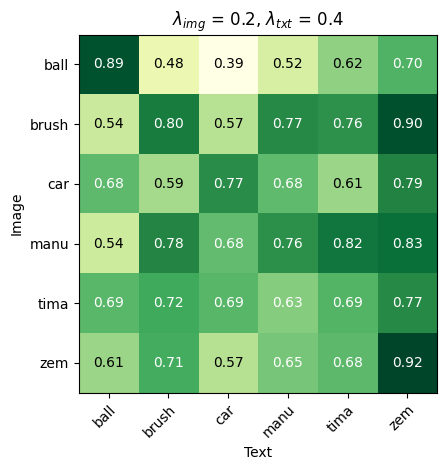

In [62]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
im = ax.imshow(rep_arr, cmap="YlGn")
ax.set_xticks(np.arange(len(OBJS)), labels=OBJS)
ax.set_yticks(np.arange(len(OBJS)), labels=OBJS)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", \
    rotation_mode="anchor")
for img in range(len(OBJS)):
    for txt in range(len(OBJS)):
        text = ax.text(txt, img, f'{rep_arr[img, txt]:.2f}', \
            ha="center", va="center", color=("k", "w")[int(im.norm(rep_arr[img, txt]) > (rep_arr.max()/2))])
plt.xlabel("Text")
plt.ylabel("Image")
img_lambda = 0.2
txt_lambda = 0.4
plt.title(f"$\lambda_{{img}}$ = {img_lambda}, $\lambda_{{txt}}$ = {txt_lambda}")

fig.tight_layout()
plt.show()

In [7]:
mlp.layer_mat.state_dict()['weight']

tensor([[ 0.0282, -0.1324,  0.1057,  0.0382,  0.0670, -0.0065, -0.0623, -0.0939,
          0.1063, -0.0954, -0.1072, -0.0676, -0.0211,  0.0738, -0.0429, -0.0945,
          0.0222,  0.1297,  0.1254, -0.0041,  0.0095,  0.0560, -0.1052, -0.1171,
         -0.0166, -0.1038, -0.0847,  0.1009, -0.1094, -0.0537,  0.0489, -0.0889,
          0.0726, -0.0929, -0.0899,  0.1157,  0.0045,  0.1056, -0.0879,  0.1263,
         -0.0622,  0.0388,  0.0130,  0.1267, -0.0469,  0.1064, -0.0496, -0.0203,
          0.0287, -0.0238,  0.0255, -0.0169, -0.1174, -0.1121, -0.0336, -0.0379,
         -0.0666, -0.0914, -0.0949,  0.0295, -0.0145, -0.0766, -0.0405,  0.1211,
         -0.0390, -0.0513,  0.0709, -0.0805,  0.0867, -0.0808,  0.0880,  0.0880,
         -0.0849,  0.0385, -0.0681,  0.0641,  0.0256,  0.0065,  0.1046, -0.0805,
          0.0833,  0.0986, -0.0695,  0.1285,  0.0494,  0.0777,  0.0193, -0.0054,
          0.0340,  0.0802, -0.1075,  0.0774,  0.0091,  0.0939, -0.0462,  0.0973,
          0.0462,  0.1165,  

## Eval viz

In [9]:
eval = pd.read_csv("eval.csv")

In [10]:
eval

,Unnamed: 0,img,txt,hid,lr,path,img_f1,txt_f1,mat_f1
0,0,0.2,0.8,128.0,0.0001,img_0.2_txt_0.8_hid_128_lr_0.0001,0.665760,0.945190,0.483685
1,1,0.6,0.0,128.0,0.0001,img_0.6_txt_0.0_hid_128_lr_0.0001,0.833747,0.097811,0.796543
2,2,0.8,0.0,128.0,0.0001,img_0.8_txt_0.0_hid_128_lr_0.0001,0.844921,0.088781,0.784304
3,3,0.2,0.2,128.0,0.0001,img_0.2_txt_0.2_hid_128_lr_0.0001,0.636570,0.836382,0.759316
4,4,0.0,1.0,128.0,0.0001,img_0.0_txt_1.0_hid_128_lr_0.0001,0.079788,0.948150,0.468053
5,5,0.4,0.6,128.0,0.0001,img_0.4_txt_0.6_hid_128_lr_0.0001,0.786520,0.939280,0.504808
6,6,1.0,0.0,128.0,0.0001,img_1.0_txt_0.0_hid_128_lr_0.0001,0.844521,0.068000,0.272085
7,7,0.0,0.4,128.0,0.0001,img_0.0_txt_0.4_hid_128_lr_0.0001,0.088993,0.953493,0.773037
8,8,0.2,0.6,128.0,0.0001,img_0.2_txt_0.6_hid_128_lr_0.0001,0.685257,0.937782,0.793572
9,9,0.6,0.4,128.0,0.0001,img_0.6_txt_0.4_hid_128_lr_0.0001,0.815613,0.939280,0.253623


In [18]:
img_f1s = np.zeros((6,6))
txt_f1s = np.zeros((6,6))
mat_f1s = np.zeros((6,6))

for _, row in eval.iterrows():
    img_idx = 5 - int(row['img'] * 5)
    txt_idx = int(row['txt'] * 5)
    img_f1s[img_idx, txt_idx] = row['img_f1']
    txt_f1s[img_idx, txt_idx] = row['txt_f1']
    mat_f1s[img_idx, txt_idx] = row['mat_f1']

In [19]:
img_f1s

array([[0.84452079, 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.84492133, 0.82639057, 0.        , 0.        , 0.        ,
        0.        ],
       [0.83374692, 0.82773952, 0.81561319, 0.        , 0.        ,
        0.        ],
       [0.7359081 , 0.76133189, 0.82086247, 0.78651955, 0.        ,
        0.        ],
       [0.28476925, 0.63656961, 0.69329997, 0.68525746, 0.66576048,
        0.        ],
       [0.09066496, 0.13742138, 0.08899291, 0.04635182, 0.04119461,
        0.07978841]])

In [32]:
LAMBDAS = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
fig, ax = plt.subplots()
im = ax.imshow(mat_f1s, cmap="Purples")
ax.set_xticks(np.arange(len(LAMBDAS)), labels=LAMBDAS)
ax.set_yticks(np.arange(len(LAMBDAS)), labels=LAMBDAS[::-1])
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", \
    rotation_mode="anchor")
for img in range(len(LAMBDAS)):
    for txt in range(len(LAMBDAS)):
        text = ax.text(txt, img, f'{mat_f1s[img, txt]:.2f}' if mat_f1s[img, txt] > 0 else "", \
            ha="center", va="center", color=("k", "w")[int(im.norm(mat_f1s[img, txt]) > (mat_f1s.max()/2))])
plt.xlabel("$\lambda_{txt}$")
plt.ylabel("$\lambda_{img}$")
plt.title(f"Match F1 scores")

fig.tight_layout()
plt.savefig(f"eval_plots/mat_f1s.png")
plt.close()

In [33]:
close_df = pd.read_csv("closeness.csv")

closeness = np.zeros((6,6))

for _, row in close_df.iterrows():
    img_idx = 5 - int(row['img'] * 5)
    txt_idx = int(row['txt'] * 5)
    closeness[img_idx, txt_idx] = row['closeness']

In [39]:
LAMBDAS = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
fig, ax = plt.subplots()
im = ax.imshow(closeness, cmap="YlGn")
ax.set_xticks(np.arange(len(LAMBDAS)), labels=LAMBDAS)
ax.set_yticks(np.arange(len(LAMBDAS)), labels=LAMBDAS[::-1])
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", \
    rotation_mode="anchor")
for img in range(len(LAMBDAS)):
    for txt in range(len(LAMBDAS)):
        text = ax.text(txt, img, f'{closeness[img, txt]:.2f}' if closeness[img, txt] != 0.0 else "", \
            ha="center", va="center", color=("k", "w")[int(im.norm(closeness[img, txt]) > 0.5)])
plt.xlabel("$\lambda_{txt}$")
plt.ylabel("$\lambda_{img}$")
plt.title(f"Closeness scores")

fig.tight_layout()
plt.savefig(f"eval_plots/closeness.png")
plt.close()

### Eval diff

In [18]:
eval = pd.read_csv("eval_lambda_diff.csv")

In [19]:
img_f1s = np.zeros((6,6))
txt_f1s = np.zeros((6,6))
mat_f1s = np.zeros((6,6))

for _, row in eval.iterrows():
    img_idx = 5 - int(row['img'] * 5)
    txt_idx = int(row['txt'] * 5)
    img_f1s[img_idx, txt_idx] = row['img_fn_diff']
    txt_f1s[img_idx, txt_idx] = row['txt_fn_diff']

In [23]:
LAMBDAS = [0, 0.2, 0.4, 0.6, 0.8, 1]

for f1s, col, lbl, fpre in zip([img_f1s, txt_f1s], ["Reds", "Blues"], ["Image", "Text"], ["img", "txt"]):
    fig, ax = plt.subplots()
    im = ax.imshow(f1s, cmap=col)
    ax.set_xticks(np.arange(len(LAMBDAS)), labels=LAMBDAS)
    ax.set_yticks(np.arange(len(LAMBDAS)), labels=LAMBDAS[::-1])
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", \
        rotation_mode="anchor")
    for img in range(len(LAMBDAS)):
        for txt in range(len(LAMBDAS)):
            text = ax.text(txt, img, f'{f1s[img, txt]:.2f}' if f1s[img, txt] != 0 else "", \
                ha="center", va="center", color=("k", "w")[int(im.norm(f1s[img, txt]) > 0.5)])
    plt.xlabel("$\lambda_{txt}$")
    plt.ylabel("$\lambda_{img}$")
    plt.title(f"{lbl} F1 score familiarity biases")

    fig.tight_layout()
    plt.savefig(f"eval_plots/{fpre}_f1s_diff.png")
    plt.close()

### Eval hard

In [27]:
# eval_hard = pd.read_csv("eval_hard.csv")
eval_hard = pd.read_csv("eval_multi.csv")

In [28]:
img_f1s = np.zeros((4,4))
txt_f1s = np.zeros((4,4))
mat_f1s = np.zeros((4,4))

for _, row in eval_hard.iterrows():
    img_idx = 4 - int(row['img'] * 5)
    txt_idx = int(row['txt'] * 5) - 1
    img_f1s[img_idx, txt_idx] = row['img_f1']
    txt_f1s[img_idx, txt_idx] = row['txt_f1']
    mat_f1s[img_idx, txt_idx] = row['mat_f1']

In [13]:
img_f1s

array([[0.77379996, 0.        , 0.        , 0.        ],
       [0.74666643, 0.76868792, 0.        , 0.        ],
       [0.69418428, 0.73696552, 0.75909903, 0.        ],
       [0.38896693, 0.64913594, 0.65706306, 0.70774555]])

In [29]:
LAMBDAS = [0.2, 0.4, 0.6, 0.8]

for f1s, col, lbl, fpre in zip([img_f1s, txt_f1s, mat_f1s], ["Reds", "Blues", "Purples"], ["Image", "Text", "Match"], ["img", "txt", "mat"]):
    fig, ax = plt.subplots()
    im = ax.imshow(f1s, cmap=col)
    ax.set_xticks(np.arange(len(LAMBDAS)), labels=LAMBDAS)
    ax.set_yticks(np.arange(len(LAMBDAS)), labels=LAMBDAS[::-1])
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", \
        rotation_mode="anchor")
    for img in range(len(LAMBDAS)):
        for txt in range(len(LAMBDAS)):
            text = ax.text(txt, img, f'{f1s[img, txt]:.2f}' if f1s[img, txt] > 0 else "", \
                ha="center", va="center", color=("k", "w")[int(im.norm(f1s[img, txt]) > (f1s.max()/2))])
    plt.xlabel("$\lambda_{txt}$")
    plt.ylabel("$\lambda_{img}$")
    plt.title(f"{lbl} F1 scores")

    fig.tight_layout()
    plt.savefig(f"eval_plots/{fpre}_f1s_multi.png")
    plt.close()

### Eval hard diff

In [30]:
eval_hard = pd.read_csv("eval_hard_diff.csv")

In [31]:
img_f1s = np.zeros((4,4))
txt_f1s = np.zeros((4,4))
mat_f1s = np.zeros((4,4))

for _, row in eval_hard.iterrows():
    img_idx = 4 - int(row['img'] * 5)
    txt_idx = int(row['txt'] * 5) - 1
    img_f1s[img_idx, txt_idx] = row['img_eh_diff']
    txt_f1s[img_idx, txt_idx] = row['txt_eh_diff']

In [33]:
LAMBDAS = [0.2, 0.4, 0.6, 0.8]

for f1s, col, lbl, fpre in zip([img_f1s, txt_f1s], ["Reds", "Blues"], ["Image", "Text"], ["img", "txt"]):
    fig, ax = plt.subplots()
    im = ax.imshow(f1s, cmap=col)
    ax.set_xticks(np.arange(len(LAMBDAS)), labels=LAMBDAS)
    ax.set_yticks(np.arange(len(LAMBDAS)), labels=LAMBDAS[::-1])
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", \
        rotation_mode="anchor")
    for img in range(len(LAMBDAS)):
        for txt in range(len(LAMBDAS)):
            text = ax.text(txt, img, f'{f1s[img, txt]:.2f}' if f1s[img, txt] != 0 else "", \
                ha="center", va="center", color=("k", "w")[int(im.norm(f1s[img, txt]) > 0.5)])
    plt.xlabel("$\lambda_{txt}$")
    plt.ylabel("$\lambda_{img}$")
    plt.title(f"{lbl} F1 score easiness bias")

    fig.tight_layout()
    plt.savefig(f"eval_plots/{fpre}_f1s_hard_diff.png")
    plt.close()

## Descriptives

In [47]:
all_naming = pd.read_csv("frame-extraction/all_namings_cleaned.csv")

In [60]:
img_hist = all_naming.groupby(['img_label'])['img_label'].count()
txt_hist = all_naming.groupby(['txt_label'])['txt_label'].count()

all_naming['mat_label'] = all_naming.apply(lambda row: row['img_label'] == row['txt_label'], axis=1)
mat_hist = all_naming.groupby(['mat_label'])['mat_label'].count()

In [56]:
fig, ax = plt.subplots()
im = ax.bar(np.arange(len(OBJS)), img_hist, color='#f03e26')
ax.set_xticks(np.arange(len(OBJS)), labels=OBJS)
plt.xlabel("Image")
plt.ylabel("Count")
plt.savefig(f"desc_plots/img_hist.png")
plt.close()

In [57]:
fig, ax = plt.subplots()
im = ax.bar(np.arange(len(OBJS)), txt_hist, color='#2666f0')
ax.set_xticks(np.arange(len(OBJS)), labels=OBJS)
plt.xlabel("Text")
plt.ylabel("Count")
plt.savefig(f"desc_plots/txt_hist.png")
plt.close()

In [66]:
fig, ax = plt.subplots()
im = ax.bar(np.arange(2), mat_hist, color='#8126f0')
ax.set_xticks(np.arange(2), labels=['Non-match', 'Match'])
plt.xlabel("Match type")
plt.ylabel("Count")
plt.savefig(f"desc_plots/mat_hist.png")
plt.close()